In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)
time_step = 100

x, y = create_dataset(df1, time_step)

X_train = x[:train_size-100]
X_test = x[train_size-100:]
y_train = y[:train_size-100]
ytest = y[train_size-100:]

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
19/19 [==============================] - 6s 115ms/step - loss: 0.0438 - val_loss: 0.0301
Epoch 2/100
19/19 [==============================] - 1s 55ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 3/100
19/19 [==============================] - 1s 54ms/step - loss: 0.0022 - val_loss: 9.6812e-04
Epoch 4/100
19/19 [==============================] - 1s 55ms/step - loss: 6.3810e-04 - val_loss: 9.1560e-05
Epoch 5/100
19/19 [==============================] - 1s 53ms/step - loss: 4.6555e-04 - val_loss: 6.9092e-05
Epoch 6/100
19/19 [==============================] - 1s 55ms/step - loss: 4.3905e-04 - val_loss: 8.9439e-05
Epoch 7/100
19/19 [==============================] - 1s 54ms/step - loss: 4.0979e-04 - val_loss: 7.7036e-05
Epoch 8/100
19/19 [==============================] - 1s 54ms/step - loss: 3.9146e-04 - val_loss: 8.0541e-05
Epoch 9/100
19/19 [==============================] - 1s 56ms/step - loss: 3.7992e-04 - val_loss: 6.6323e-05
Epoch 10/100
19/19 [===========================

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

10/10 [==============================] - 0s 12ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 15563.830791976237


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99956396560141
Testing MAE: 15365.586331567569


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.04652344062924385], [0.044831570237874985], [0.04286348074674606], [0.040749870240688324], [0.038527119904756546], [0.03621291741728783], [0.03381914272904396], [0.03135453164577484], [0.028825588524341583], [0.026237282902002335], [0.02359342947602272], [0.020896952599287033], [0.018150128424167633], [0.01535469014197588], [0.012511969543993473], [0.009622979909181595], [0.0066884467378258705], [0.0037089018151164055], [0.0006846915930509567], [-0.002383971121162176], [-0.005496996454894543], [-0.008654388599097729], [-0.011856230907142162], [-0.015102664940059185], [-0.018393896520137787], [-0.021730177104473114], [-0.02511177957057953], [-0.0285390242934227], [-0.03201223537325859], [-0.03553176671266556], [-0.039097998291254044], [-0.0427112951874733], [-0.04637204855680466], [-0.05008064955472946], [-0.053837478160858154], [-0.057642966508865356], [-0.06149747595191002], [-0.06540140509605408], [-0.06935514509677887], [-0.07335907220840454], [-0.07741357386112213], [-0.0815190

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[ 14070.31885071],
       [ 13931.38922165],
       [ 13769.777585  ],
       [ 13596.21634468],
       [ 13413.6929781 ],
       [ 13223.65992664],
       [ 13027.09272434],
       [ 12824.70872062],
       [ 12617.04202726],
       [ 12404.50072278],
       [ 12187.39805485],
       [ 11965.97415964],
       [ 11740.41594568],
       [ 11510.8657357 ],
       [ 11277.43289107],
       [ 11040.20061822],
       [ 10799.22849232],
       [ 10554.56018145],
       [ 10306.22413485],
       [ 10054.23782741],
       [  9798.60863911],
       [  9539.3362258 ],
       [  9276.41374283],
       [  9009.82956578],
       [  8739.56679335],
       [  8465.60477689],
       [  8187.92110878],
       [  7906.48948112],
       [  7621.28328009],
       [  7332.27344462],
       [  7039.42877232],
       [  6742.71928439],
       [  6442.11286071],
       [  6137.57738116],
       [  5829.08164334],
       [  5516.59016216],
       [  5200.07326473],
       [  4879.49821913],
       [  45

In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(420,)


(320, 1)

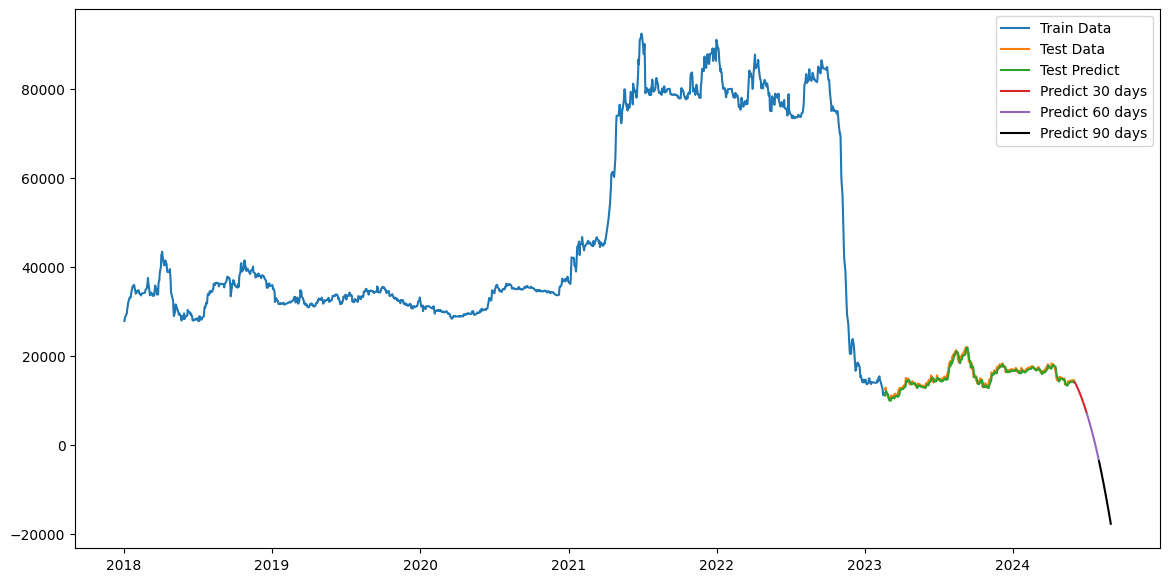

In [20]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred)], y_pred, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()